## First attempt at combining the alm, wigner rotations and visibility response

In [1]:
import os
import numpy as np
import pylab as plt

import healpy as hp
import pyuvsim
from pyuvdata import UVBeam

# Hydra
import sys
sys.path.append("/home/phil/hera/Hydra") # change this to your own path
import hydra

# Linear solver 
from scipy.sparse.linalg import cg, LinearOperator

# All things astropy
from astropy import units
from astropy.coordinates import EarthLocation, SkyCoord
from astropy.coordinates.builtin_frames import AltAz, ICRS
from astropy.time import Time

import time

In [2]:
%load_ext memory_profiler

## Solving the linear system $A x = b$

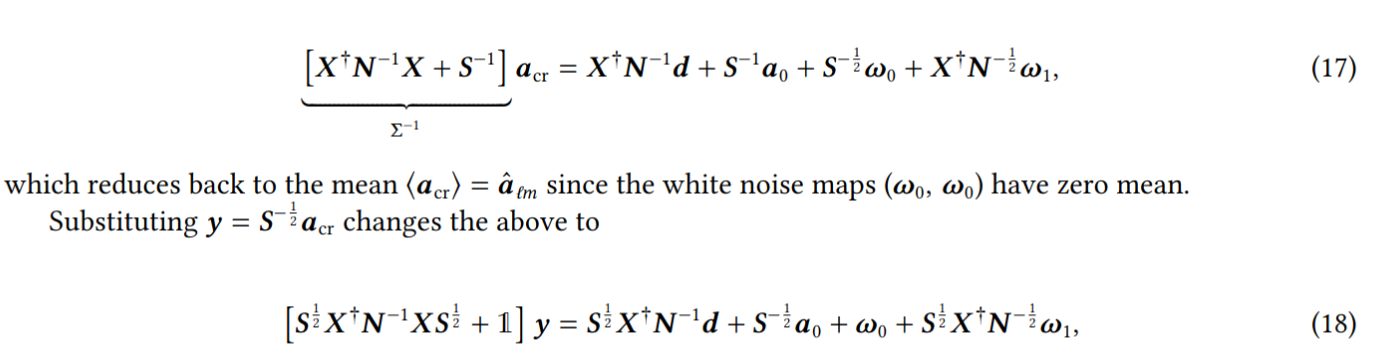

In [3]:
def vis_proj_operator_lsts(freqs, lsts, beams, ant_pos, lmax, nside, latitude=-0.5361913261514378):
    """
    Visibility projection operator, constructed from each a_lm.
    """
    # Get 
    ell, m, vis_alm = hydra.vis_simulator.simulate_vis_per_alm(lmax=lmax, 
                                                               nside=nside, 
                                                               ants=ant_pos, 
                                                               freqs=freqs, 
                                                               lsts=lsts, 
                                                               beams=beams,
                                                               latitude=latitude)
    # Construct list of antenna pairs
    ants = list(ant_pos.keys())
    antpairs = []
    for i in ants:
        for j in ants:
            if j >= i:
                antpairs.append((ants[i],ants[j]))
    
    
    vis_response = np.zeros((len(antpairs), len(freqs), len(lsts), 2*len(ell)), dtype=np.complex128)

    for i, bl in enumerate(antpairs):
        idx1 = ants.index(bl[0])
        idx2 = ants.index(bl[1])
        vis_response[i, :, :, :] = vis_alm[:, :, idx1, idx2, :] 
        
    return vis_response, antpairs, ell, m

In [4]:
def trim_X_operator(vis_response, antpairs, ell, m):
    """
    Remove m=0 imaginary modes and auto-baselines from operator.
    """
    print(vis_response.shape, len(antpairs), len(ell), len(m))
    
    # Get indices of auto-baselines (we want to exclude these)
    auto_idxs = []
    new_antpairs = []
    for i, bl in enumerate(antpairs):
        if bl[0] == bl[1]:
            auto_idxs.append(i)
        else:
            new_antpairs.append(bl)
    auto_idxs = np.array(auto_idxs, dtype=int)
    print(auto_idxs)
    
    # Get indices of m=0 imaginary modes (these are always zero)
    # Original ordering is all the real parts of the a_lm modes, 
    # in healpix ordering, then all the imaginary parts.
    imagm_idxs = np.where(m == 0)[0] + len(m)
    new_ells = np.concatenate((ell, ell[np.where(m != 0)]))
    new_ms = np.concatenate((m, m[np.where(m != 0)]))
    
    # Remove selected entries
    v1 = np.delete(vis_response, auto_idxs, axis=0)
    v2 = np.delete(v1, imagm_idxs, axis=3)
    return v2, new_antpairs, new_ells, new_ms

In [5]:
def build_hex_array(hex_spec=(3,4), ants_per_row=None, d=14.6):
    """
    Build an antenna position dict for a hexagonally close-packed array.
    
    Parameters
    ----------
    hex_spec : tuple, optional
        If `ants_per_row = None`, this is used to specify a hex array as 
        `hex_spec = (nmin, nmax)`, where `nmin` is the number of antennas in 
        the bottom and top rows, and `nmax` is the number in the middle row. 
        The number per row increases by 1 until the middle row is reached.
        
        Default: (3,4) [a hex with 3,4,3 antennas per row]
    
    ants_per_row : array_like, optional
        Number of antennas per row. Default: None.
    
    d : float, optional
        Minimum baseline length between antennas in the hex array, in meters. 
        Default: 14.6.
    
    Returns
    -------
    ants : dict
        Dictionary with antenna IDs as the keys, and tuples with antenna 
        (x, y, z) position values (with respect to the array center) as the 
        values. Units: meters.
    """
    ants = {}
    
    # If ants_per_row isn't given, build it from hex_spec
    if ants_per_row is None:
        r = np.arange(hex_spec[0], hex_spec[1]+1).tolist()
        ants_per_row = r[:-1] + r[::-1]
    
    # Assign antennas
    k = -1
    y = 0.
    dy = d * np.sqrt(3) / 2. # delta y = d sin(60 deg)
    for j, r in enumerate(ants_per_row):
        
        # Calculate y coord and x offset
        y = -0.5 * dy * (len(ants_per_row)-1) + dy * j
        x = np.linspace(-d*(r-1)/2., d*(r-1)/2., r)
        for i in range(r):
            k += 1
            ants[k] = (x[i], y, 0.)
            
    return ants

## Realified matrix solver

In [26]:
# Make X (projection operator)
lst_ref = 1.
latitude = -30.7215 * np.pi / 180.
lmax = 70

ant_pos = {0: (0., 0., 0.), 
           1: (14., 0., 0.),
           2: (0., 14., 0.),
           3: (14., 14., 0.),
           4: (-14., 14., 0.),
           5: (28., 0., 0.),
           6: (0., 28., 0.),
           7: (28., 28., 0.),
           8: (-28., 28., 0.),
           9: (42., 0., 0.),
           10: (0., 42., 0.),
           11: (42., 42., 0.),
           12: (-42., 42., 0.),
           #13: (4.*14, 0., 0.),
           #14: (0., 4.*14, 0.),
           #15: (4.*14, 4.*14, 0.),
           #16: (-4.*14, 4.*14, 0.),
           #17: (5.*14, 0., 0.),
           #18: (0., 5.*14, 0.),
           #19: (5.*14, 5.*14, 0.),
           #20: (-5.*14, 5.*14, 0.),
          }

freqs = np.linspace(100e6, 110e6, 1)
lsts = np.linspace(0.01, 2., 2)
beams = [pyuvsim.AnalyticBeam('gaussian', diameter=14.) for ant in ant_pos]

# Get raw projection operator
t0 = time.time()
%memit vis_response, _antpairs, _ell, _m = vis_proj_operator_lsts(freqs, lsts, beams, ant_pos, lmax=lmax, nside=64, latitude=latitude)
print("Run took %5.3f sec" % (time.time() - t0))

# Trim unwanted entries
t0 = time.time()
%memit Xarr, antpairs, ell, m = trim_X_operator(vis_response, _antpairs, _ell, _m)
print("Run took %5.3f sec" % (time.time() - t0))
X = Xarr.reshape((-1, Xarr.shape[-1]))

peak memory: 3355.70 MiB, increment: 540.34 MiB
Run took 445.649 sec
(91, 1, 2, 5112) 91 2556 2556
[ 0 13 25 36 46 55 63 70 76 81 85 88 90]
(91, 1, 2, 5112) 91 2556 2556
[ 0 13 25 36 46 55 63 70 76 81 85 88 90]
(91, 1, 2, 5112) 91 2556 2556
[ 0 13 25 36 46 55 63 70 76 81 85 88 90]
peak memory: 2829.16 MiB, increment: 0.00 MiB
Run took 0.327 sec


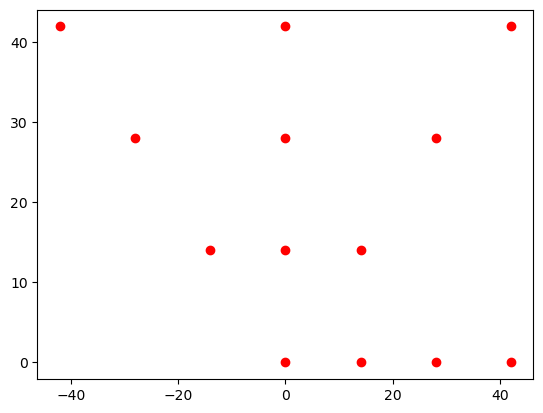

In [27]:
# Plot antenna positions
for ant in ant_pos.keys():
    plt.plot(ant_pos[ant][0], ant_pos[ant][1], 'ro')

In [28]:
# Check shape of X operator
print(X.shape)

# Define simple S and N matrices
S = (2e4)**2. * np.eye(X.shape[-1])
N = (0.001)**2. * np.ones((Xarr.shape[0], Xarr.shape[1], Xarr.shape[2])) # actually a vector here

Sinv = np.zeros_like(S)
Sinv[np.diag_indices(S.shape[0])] = 1. / np.diag(S)
Ninv = 1. / N
Ninv = Ninv.flatten()[:,np.newaxis]

# Define example vector
np.random.seed(10)
a_true = 1e4 * np.random.randn(X.shape[-1]) # randomly choose true a_lms
a0 = np.zeros_like(a_true) # Prior mean is zero

# Construct example data by applying X projection operator to randomly-chosen true a_lms 
# plus random noise
model_true = np.matmul(X, a_true).reshape(N.shape)
data = model_true + np.sqrt(N) * np.random.randn(*N.shape)
data_vec = data.flatten()

(156, 5041)


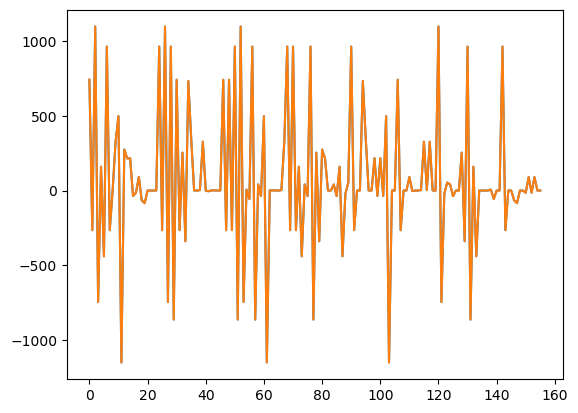

In [29]:
# Plot resulting data vector (flattened)
plt.plot(model_true.flatten().real)
plt.plot(data.flatten().real)

(5041, 5041)
1.935e+13


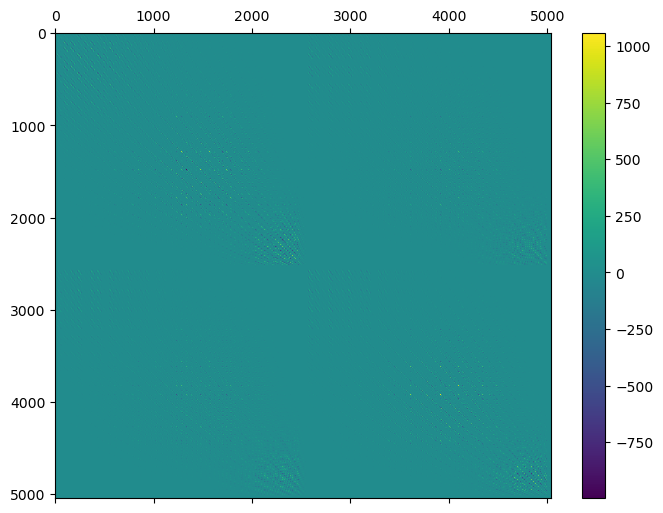

In [30]:
# Construct LHS matrix
# From Eq. 8 of my note
Amat = Sinv \
     + np.matmul(X.real.T, Ninv * X.real) \
     + np.matmul(X.imag.T, Ninv * X.imag)
print(Amat.shape)

plt.matshow(Amat, aspect='auto')
plt.colorbar()
plt.gcf().set_size_inches((8., 6.))

print("%5.3e" % np.linalg.cond(Amat))
# condition number (bigger value = worse conditioning = harder to solve numerically)

In [31]:
# Construct RHS vector
omega_d = np.sqrt(0.5) * (np.random.randn(*data_vec.shape) 
                          + 1.j * np.random.randn(*data_vec.shape))
omega_a = np.random.randn(*a0.shape) # purely real

bvec = np.matmul(X.real.T, Ninv.flatten() * data_vec.real 
                          + np.sqrt(Ninv.flatten()) * omega_d.real) \
     + np.matmul(X.imag.T, Ninv.flatten() * data_vec.imag 
                          + np.sqrt(Ninv.flatten()) * omega_d.imag) \
     + np.matmul(Sinv, a0) \
     + np.matmul(np.sqrt(Sinv), omega_a)

print(bvec)

[ 782989.2242769   427079.66448526 -753984.0075262  ...  -91074.69518724
 -345348.6098836    -7643.45941452]


|A x_soln - b| = 3.396e-04


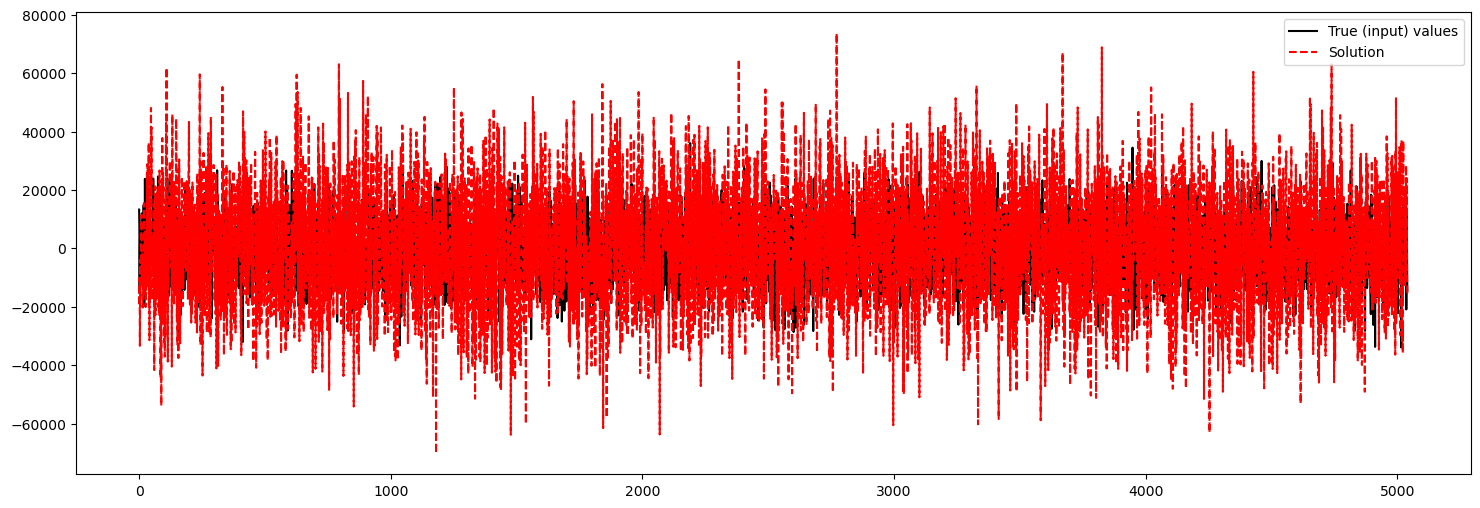

In [32]:
# Try solving using general-purpose numpy solver
a_soln = np.linalg.solve(Amat, bvec)
print("|A x_soln - b| = %7.3e" % np.sum(np.abs(np.matmul(Amat, a_soln) - bvec)))

# Plot results
plt.plot(a_true, 'k-', label="True (input) values")
plt.plot(a_soln, 'r--', label="Solution")

plt.legend(loc='upper right')
plt.gcf().set_size_inches((18., 6.))

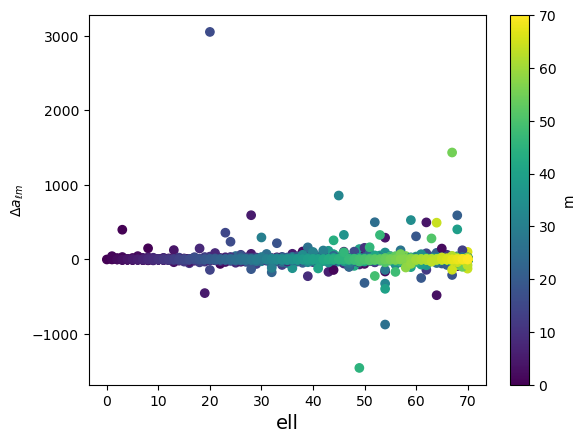

In [33]:
plt.scatter(ell, a_soln/a_true - 1, c=m)

plt.xlabel("ell", fontsize=14)
plt.ylabel("$\Delta a_{\ell m}$")
plt.colorbar(label="m")

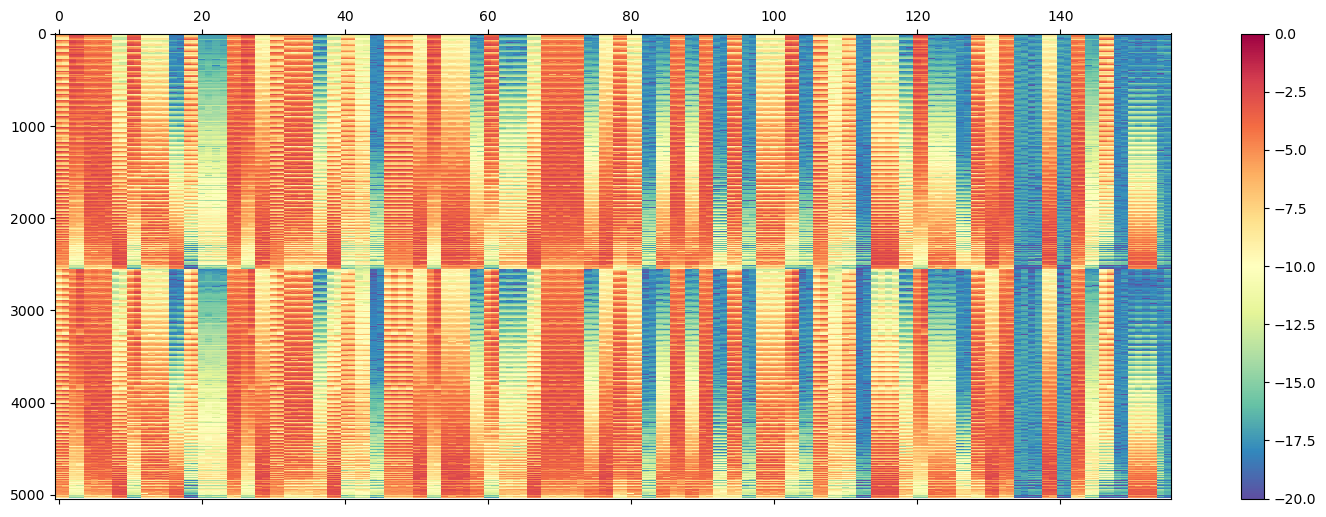

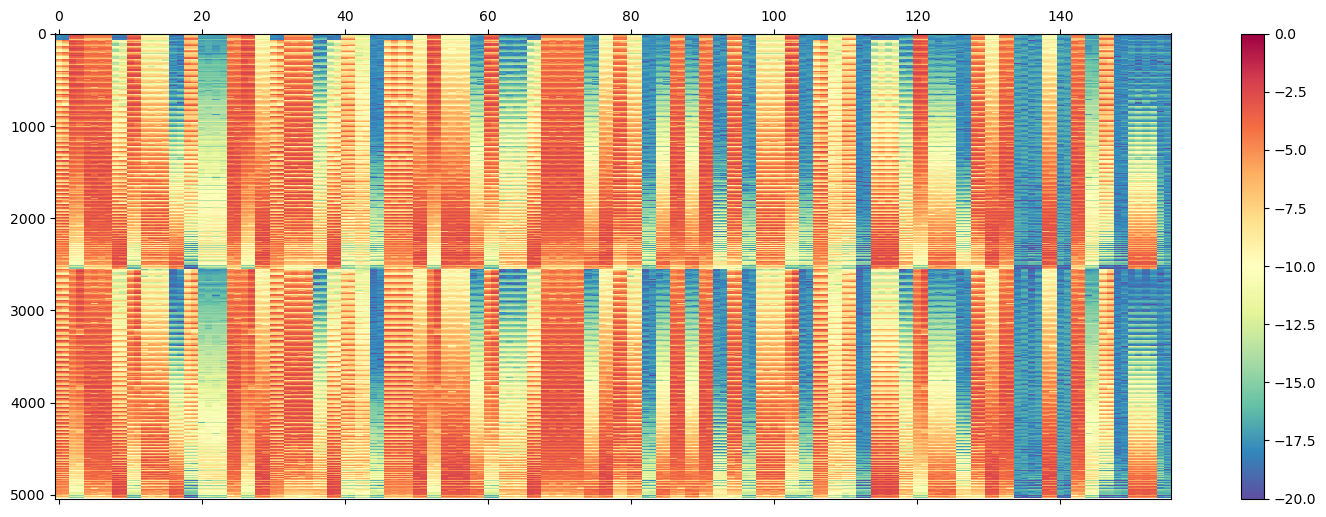

In [34]:
# Plot X matrix real and imaginary parts
plt.matshow(np.log10(np.abs(X.real)).T, aspect='auto', vmin=-20, vmax=0, cmap='Spectral_r')
plt.colorbar()
plt.gcf().set_size_inches((18., 6.))
plt.show()

plt.matshow(np.log10(np.abs(X.imag)).T, aspect='auto', vmin=-20, vmax=0, cmap='Spectral_r')
plt.colorbar()
plt.gcf().set_size_inches((18., 6.))
plt.show()

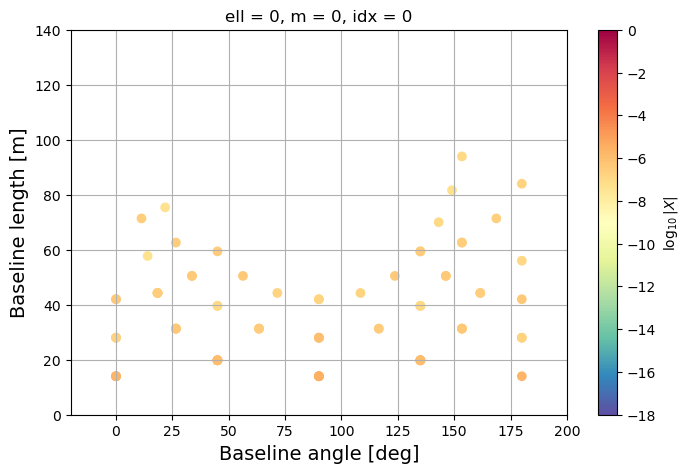

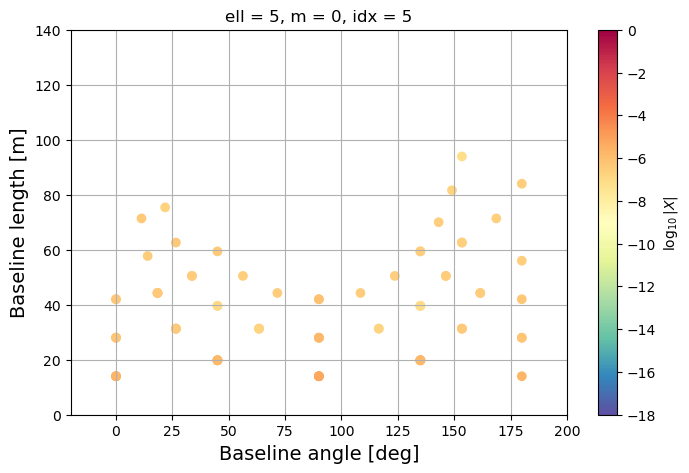

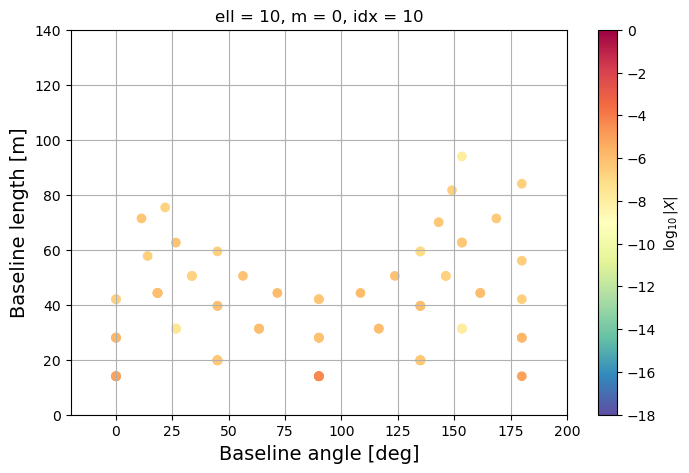

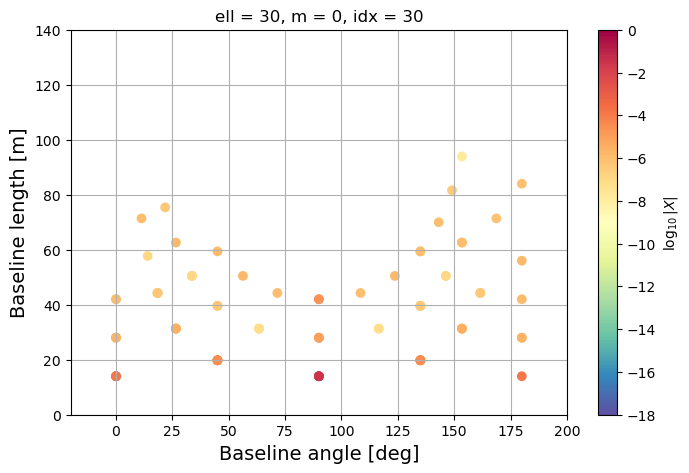

In [25]:
for idx in [0, 5, 10, 30]: #np.arange(len(ell)):
    angs = []
    logmags = []
    bllens = []
    for i, bl in enumerate(antpairs):
        x1, y1, z1 = ant_pos[bl[0]]
        x2, y2, z2 = ant_pos[bl[1]]
        bllen = np.sqrt((x1 - x2)**2. + (y1 - y2)**2.)
        ang = np.arccos((x2 - x1) / bllen) * 180. / np.pi
        logmag = np.log10(np.abs(Xarr[i,0,1,idx].real))
        # Xarr Shape: (Nbls, Nfreqs, Nlsts, Nmodes)
        #print("%03d" % i, "%10s" % str(bl), "%7.1f" % logmag, "%7.2f m" % bllen, "%7.1f deg" % ang)

        bllens.append(bllen)
        angs.append(ang)
        logmags.append(logmag)

    plt.scatter(angs, bllens, c=logmags, cmap='Spectral_r', vmax=0., vmin=-18.)
    plt.title("ell = %d, m = %d, idx = %d" % (ell[idx], m[idx], idx))
    plt.colorbar(label="$\log_{10}|X|$")
    plt.xlim((-20., 200.))
    plt.ylim((0., 140.))
    plt.grid()
    
    plt.xlabel("Baseline angle [deg]", fontsize=14)
    plt.ylabel("Baseline length [m]", fontsize=14)
    plt.gcf().set_size_inches((8., 5.))
    plt.show()